<a href="https://colab.research.google.com/github/CarlosBaez11/Transferencia_de_calor/blob/main/Primer_Laboratorio_Transferencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy

import csv
import numpy as np
import seaborn as sns

import sklearn as sk
from sklearn.linear_model import LinearRegression
import math

from scipy.optimize import curve_fit

Colocamos los datos entregados por el problema:

In [ ]:
"""Conduccion Axial:"""

D_laton=1*25.4 #mm
P_axial=9.7 #w
T_amb=26.5 #c



#Colocamos los datos para conduccion axial
T_foco_caliente=np.array([61.4, 59.8, 56.6])
x_foco_caliente=np.array([ 0.01, 0.02, 0.03])
l_foco_caliente=np.arange(0, 0.031, 0.001).reshape(-1, 1)


T_mitad=np.array([52, 50.1, 47.5])
x_mitad=np.array([0.040, 0.050, 0.060])
l_mitad=np.arange(0.03, 0.061, 0.001).reshape(-1, 1)

T_foco_frio=np.array([38.3, 36.8, 36.1])
x_foco_frio=np.array([0.070, 0.080, 0.090])
l_foco_frio=np.arange(0.06, 0.091, 0.001).reshape(-1, 1)

#Colocamos los datos para conduccion radial
T_radial=np.array([48.4, 40.7, 40.6, 34.6, 33.2, 31.8])
x_radial=np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06])


#Colocamos el vector que contiene la posicion para el modelo teorico: 
x_real=np.array([ 0.0, 0.01, 0.02])

Dado que el comportamiento de la temperatura en conducción axial a lo largo del cilindro se comporta de manera lineal, aplicamos regresión lineal a los datos entregados por el problema:

In [ ]:
P_foco_caliente=LinearRegression(fit_intercept=True)
P_foco_caliente.fit(x_foco_caliente.reshape(-1, 1), T_foco_caliente)
eq_foco_caliente="T(x)= {}*x + {}".format(round(P_foco_caliente.coef_[0], 3), round(P_foco_caliente.intercept_, 3))
eq_foco_caliente

'T(x)= -240.0*x + 64.067'

In [ ]:
class L_Reg(LinearRegression):
    def __init__(self,  x_data, y_data, c_type, intercept=True,):
        self.intercept=intercept
        super().__init__(fit_intercept=self.intercept)
        self.x_data=x_data
        self.y_data=y_data
        self.c_type=c_type

    def L_reg_train(self):
        if self.c_type=='axial':
            self.reg=super().fit(self.x_data, self.y_data)
            return "T(x)= {}*x + {}".format(round(self.reg.coef_[0], 3), round(self.reg.intercept_, 3))
            
        elif self.c_type=='radial':
            self.b, self.a=np.polyfit(np.log(x_radial), self.y_data, 1)
            return "T(x)= {}+{}*ln(x)".format(round(self.a, 3), round(self.b, 3))
    
    def L_reg_pred(self, l_x):
        if self.c_type=='axial':
            self.equation=self.reg.predict(l_x)
            return self.equation
        elif self.c_type=='radial':
            self.equation=self.a+self.b*np.log(l_x)
            return  self.equation
    
    def compute_loss(self, gt_data, pred_data):
        return round(sk.metrics.r2_score(gt_data, pred_data), 3)
    
    def T_teor(self, x_real, T_init):
        self.Q=9.8
        self.k=110
        self.A_c=4.9*1e-4
        if self.c_type=='axial':
            return (-self.Q/(self.A_c*self.k))*(x_real)+T_init
        if self.c_type=='radial':
            return -14.51*np.log(x_real)+5


Ahora obtenemos las ecuaciones de la recta:

In [ ]:
p1=L_Reg(x_foco_caliente.reshape(-1, 1), T_foco_caliente, c_type='axial')
eq_1=p1.L_reg_train()
r_1=p1.L_reg_pred(l_foco_caliente)
p1_pred_data=p1.L_reg_pred(x_foco_caliente.reshape(-1, 1))
loss1=p1.compute_loss(T_foco_caliente, p1_pred_data)
real_1=p1.T_teor(x_real.reshape(-1, 1), T_foco_caliente[0])

p2=L_Reg(x_mitad.reshape(-1, 1), T_mitad, c_type='axial')
eq_2=p2.L_reg_train()
r_2=p2.L_reg_pred(l_mitad)
p2_pred_data=p2.L_reg_pred(x_mitad.reshape(-1, 1))
loss2=p2.compute_loss(T_mitad, p2_pred_data)
real_2=p2.T_teor(x_real.reshape(-1, 1), T_mitad[0])

p3=L_Reg(x_foco_frio.reshape(-1, 1), T_foco_frio, c_type='axial')
eq_3=p3.L_reg_train()
r_3=p3.L_reg_pred(l_foco_frio)
p3_pred_data=p3.L_reg_pred(x_foco_frio.reshape(-1, 1))
loss3=p3.compute_loss(T_foco_frio, p3_pred_data)
real_3=p3.T_teor(x_real.reshape(-1, 1), T_foco_frio[0])


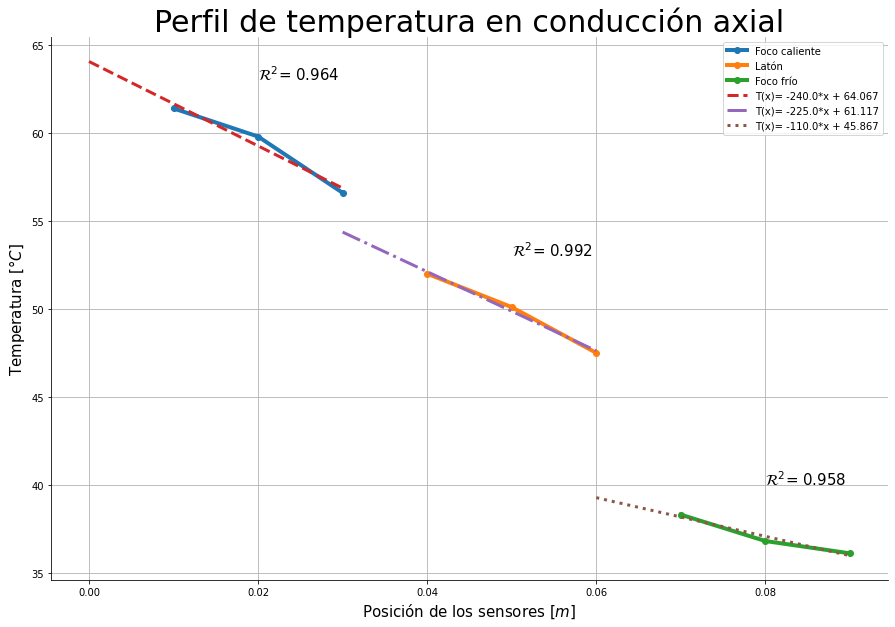

In [ ]:
fig, ax= plt.subplots(figsize=(15, 10))
ax.plot(x_foco_caliente, T_foco_caliente, label='Foco caliente', linewidth=4, marker='o' )
ax.plot(x_mitad, T_mitad, label='Latón', linewidth=4, marker='o' )
ax.plot(x_foco_frio, T_foco_frio, label='Foco frío', linewidth=4 , marker='o')

ax.text(0.02, 63, '$\mathcal{R}^{2}$= '+str(loss1), fontsize=15)
ax.text(0.05, 53, '$\mathcal{R}^{2}$= '+str(loss2), fontsize=15)
ax.text(0.08, 40, '$\mathcal{R}^{2}$= '+str(loss3), fontsize=15)


ax.set_xlabel('Posición de los sensores [$\mathit{m}$]', fontsize=15)
ax.set_ylabel('Temperatura [$\mathit{°C}$]', fontsize=15)
ax.set_title('Perfil de temperatura en conducción axial', fontsize=30)
ax.grid(True)

plt.plot(l_foco_caliente, r_1, label=eq_1, linestyle='--', linewidth=3)
plt.plot(l_mitad, r_2, label=eq_2, linestyle='dashdot', linewidth=3)
plt.plot(l_foco_frio, r_3, label=eq_3, linestyle='dotted', linewidth=3)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()

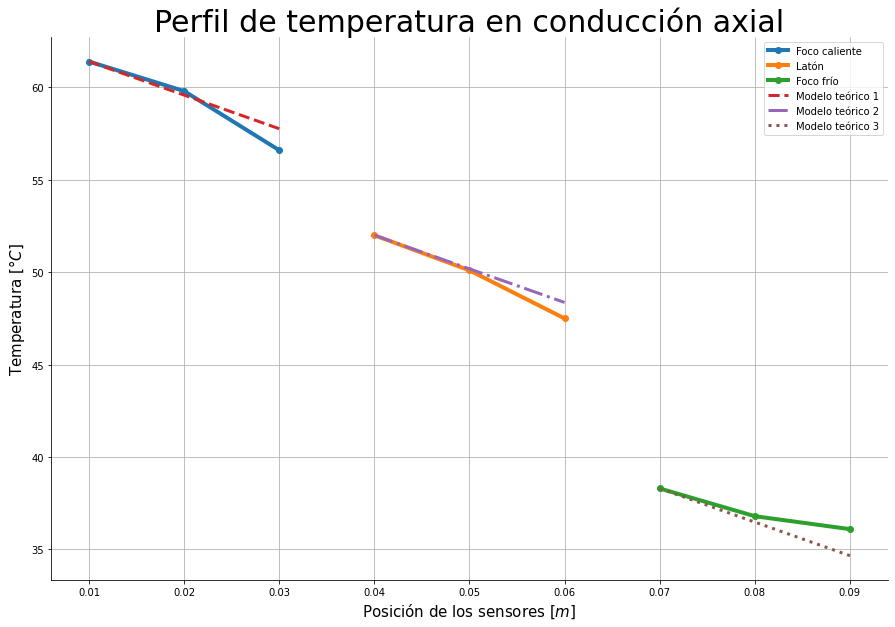

In [ ]:
fig, ax= plt.subplots(figsize=(15, 10))
ax.plot(x_foco_caliente, T_foco_caliente, label='Foco caliente', linewidth=4, marker='o' )
ax.plot(x_mitad, T_mitad, label='Latón', linewidth=4, marker='o' )
ax.plot(x_foco_frio, T_foco_frio, label='Foco frío', linewidth=4 , marker='o')


ax.set_xlabel('Posición de los sensores [$\mathit{m}$]', fontsize=15)
ax.set_ylabel('Temperatura [$\mathit{°C}$]', fontsize=15)
ax.set_title('Perfil de temperatura en conducción axial', fontsize=30)
ax.grid(True)

plt.plot(x_foco_caliente, real_1, label='Modelo teórico 1', linestyle='--', linewidth=3)
plt.plot(x_mitad, real_2, label='Modelo teórico 2', linestyle='dashdot', linewidth=3)
plt.plot(x_foco_frio, real_3, label='Modelo teórico 3', linestyle='dotted', linewidth=3)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()

Conducción Radial

In [ ]:
p4=L_Reg(x_radial.reshape(-1, 1), T_radial, c_type='radial')
eq_4=p4.L_reg_train()
r_4=p4.L_reg_pred(x_radial)
p4_pred_data=p4.L_reg_pred(x_radial)
loss4=p4.compute_loss(T_radial, p4_pred_data)


In [ ]:
x_real_rad=np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06])

In [ ]:
real_4=p4.T_teor(x_real_rad.reshape(-1, 1), T_foco_frio[0])

In [ ]:
print(real_4)

[[71.8210194 ]
 [61.76345381]
 [55.88015509]
 [51.70588822]
 [48.46807529]
 [45.8225895 ]]


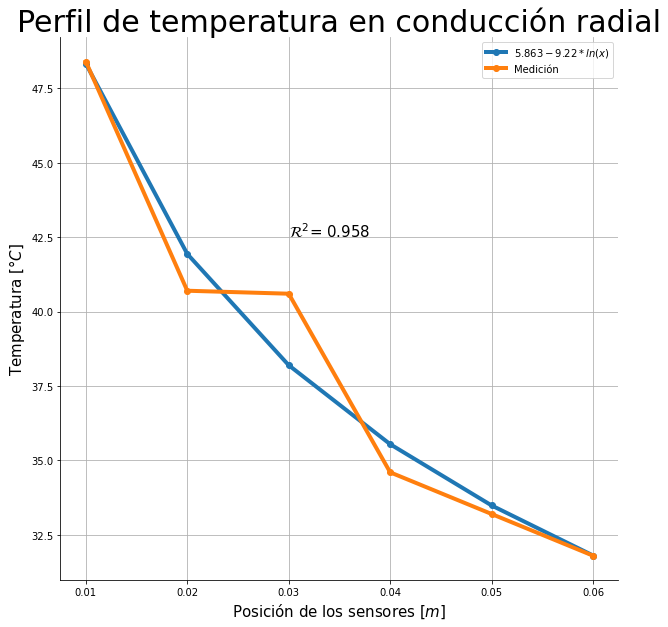

In [ ]:
fig, ax =plt.subplots(figsize=(10, 10))
ax.plot(x_radial, r_4, linewidth=4, marker='o', label='$5.863-9.22*ln(x)$' )
ax.plot(x_radial, T_radial, label='Medición', linewidth=4, marker='o' )
ax.set_xlabel('Posición de los sensores [$\mathit{m}$]', fontsize=15)
ax.set_ylabel('Temperatura [$\mathit{°C}$]', fontsize=15)
ax.set_title(r'Perfil de temperatura en conducción radial', fontsize=30)
ax.text(0.03, 42.5, '$\mathcal{R}^{2}$= '+str(loss4), fontsize=15)
ax.grid(True)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()

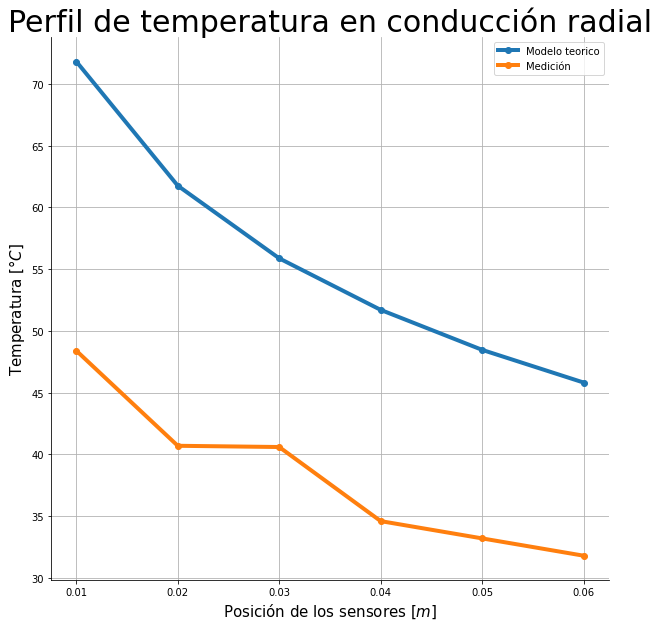

In [ ]:
fig, ax =plt.subplots(figsize=(10, 10))
ax.plot(x_real_rad, real_4, linewidth=4, marker='o', label='Modelo teorico' )
ax.plot(x_radial, T_radial, label='Medición', linewidth=4, marker='o' )
ax.set_xlabel('Posición de los sensores [$\mathit{m}$]', fontsize=15)
ax.set_ylabel('Temperatura [$\mathit{°C}$]', fontsize=15)
ax.set_title(r'Perfil de temperatura en conducción radial', fontsize=30)
ax.grid(True)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()